# Enunciado

Etapa 1: Download e exploração dos dados
Acesse os dados públicos e faça uma análise exploratória
Link: https://analyse.kmi.open.ac.uk/open_dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

assessments = pd.read_csv('anonymisedData/assessments.csv')
courses = pd.read_csv('anonymisedData/courses.csv')
studentAssessment = pd.read_csv('anonymisedData/studentAssessment.csv')
studentInfo = pd.read_csv('anonymisedData/studentInfo.csv')
studentRegistration = pd.read_csv('anonymisedData/studentRegistration.csv')
studentVle = pd.read_csv('anonymisedData/studentVle.csv')
vle = pd.read_csv('anonymisedData/vle.csv')

## Datasets

Informações retiradas do site e uma análise de cada conjunto de dados

### Courses

File contains the list of all available modules and their presentations. The columns are:

- **code_module:** code name of the module, which serves as the identifier.
- **code_presentation:** code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
- **length:** length of the module-presentation in days.

**The structure of B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately.** Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules.

#### Resumo

- Cada curso tem seu código ```code_module```, que é identificador único e uma apresentação ```code_presentation```. A combinação dos dois torna uma entrada única.
- Apresentações B costumam ser diferentes das J. É bom analisar os tipos separadamente.
- Podem existir dados faltantes. Nesse caso, é recomendável considerar os dados da apresentação anterior, mesmo que ela seja de um tipo diferente. (Módulos CCC, EEE e GGG têm esse problema)

In [2]:
courses.groupby(['code_module', 'code_presentation']).agg({'code_presentation':'count'})

code_presentation
code_module code_presentation                   
AAA         2013J                              1
            2014J                              1
BBB         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
CCC         2014B                              1
            2014J                              1
DDD         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
EEE         2013J                              1
            2014B                              1
            2014J                              1
FFF         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
GGG         2013J                              1
            2014B                              1
            2014J                              1

Todas as apresentações estão presentes, o que indica que o problema nos módulos CCC, EEE e GGG está em outro arquivo. Como é uma boa prática analizar apresentações B e J separadamente, vou criar novas colunas para ano e apresentação.

In [3]:
courses['presentation_year'] = courses['code_presentation'].str.slice(stop=-1)
courses['presentation_month'] = courses['code_presentation'].str.slice(start=-1)
courses.columns

Index(['code_module', 'code_presentation', 'module_presentation_length',
       'presentation_year', 'presentation_month'],
      dtype='object')

Essa tabela também contém informação da duração de cada uma das apresentações. Vou explorar como esses valores se comportam.

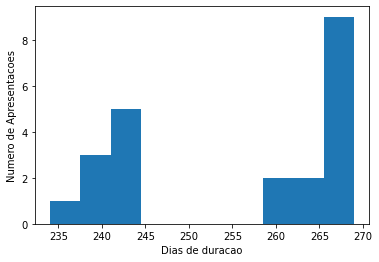

In [4]:
plt.hist(courses['module_presentation_length'])
plt.ylabel('Numero de Apresentacoes')
plt.xlabel('Dias de duracao')
plt.show()

Temos dois agrupamentos de dias. Isso pode estar relacionado ao ano ou ao periodo em que cada apresentação acontece. Podemos verificar essa relação usando um scatter plot. Como os números em cada grupo parecem somar para valores semelhantes, primeiro vou analisar a relação que o mês de início tem na duração.

Text(0.5, 0, 'Dias de duracao')

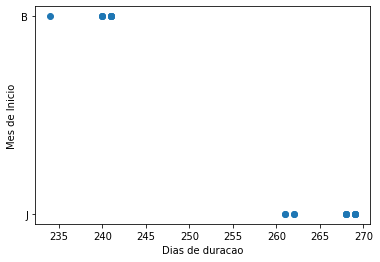

In [5]:
plt.scatter(courses['module_presentation_length'], courses['presentation_month'])
plt.ylabel('Mes de Inicio')
plt.xlabel('Dias de duracao')

Como podemos ver, o mês de início mostra uma separação clara entre apresentações que duram até ~245 dias e as que duram a partir de ~260 dias.


### Assessments

This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam. CSV contains columns:

- **code_module:** identification code of the module, to which the assessment belongs.
- **code_presentation:** identification code of the presentation, to which the assessment belongs.
- **id_assessment:** identification number of the assessment.
- **assessment_type:** type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
- **date:** information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
- **weight:** weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.
If the information about the final exam date is missing, it is at the end of the last presentation week.

#### Resumo

- A junção de ```code_module``` e ```code_presentation``` determina um curso único e deve também existir no arquivo courses.
- Não devem existir dois ou mais ```id_assessment``` únicos.
- Somente 3 tipos de avaliação: ```TMA``` (avaliada por monitor), ```CMA``` (avaliada por computador) e ```Exam``` (prova final)
- A data das avaliações é contada em dias a partir do início do curso.
- Soma dos pesos é 100% para todos os tipos de avaliação menos provas.



In [6]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


Primeiro, vou verificar se todos os cursos/apresentações listados aqui estão presentes também na base de dados de cursos.

In [7]:
assessment_modules = set(list(zip(assessments['code_module'], assessments['code_presentation'])))
courses_modules = set(list(zip(courses['code_module'], courses['code_presentation'])))

assessment_modules - courses_modules

set()

O conjunto vazio indica que todos os pares (curso, oferta) dessa tabela estão presentes também na tabela de cursos. Em seguida, vou conferir se não existem ```id_assessment``` utilizados mais de uma vez

In [8]:
np.unique(assessments['id_assessment'].value_counts().values)

array([1])

Também checando se existe algum erro de digitação ou tipo de avaliação desconhecido.

In [9]:
np.unique(assessments['assessment_type'])

array(['CMA', 'Exam', 'TMA'], dtype=object)

Esse arquivo contém dados descritivos sobre avaliações nas várias apresentações de cada curso. Aqui não estão contidas as notas de cada aluno, mas sim, o tipo de avaliação, a data em que foi aplicada, e o peso da nota.

Nesse conjunto de dados existem várias coisas que podem estar erradas:

- Como já sabemos pela descrição do próprio site, existem problemas em 3 cursos e vou checar se é o caso nesse arquivo.
- É de se esperar que os pesos de todas avaliações menos provas somem 100% do peso em uma apresentação de um curso. Isso pode gerar outras questões:
    - Se o peso de uma prova for considerado. Torno o peso da prova 100 e refaço a escala das demais avaliações.
    - Se os pesos dos trabalhos não somar 100%, posso usar informações de outras ofertas do mesmo curso.
- Menos provável de acontecer, porém ainda relevante para a predição de resultados, vou conferir se todas as avaliações aconteceram dentro do prazo de duração informado no arquivo ```courses```.

Para checar se existe problema nos cursos mencionados anteriormente, vou conferir a soma dos pesos e as datas das avaliações. Primeiro, vou ver a soma dos pesos das atividades que não são provas:

In [10]:
assessments.loc[assessments['assessment_type'].isin(['TMA', 'CMA'])].groupby(['code_module', 'code_presentation']).agg({'weight':'sum'})

weight
code_module code_presentation        
AAA         2013J               100.0
            2014J               100.0
BBB         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
CCC         2014B               100.0
            2014J               100.0
DDD         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
EEE         2013J               100.0
            2014B               100.0
            2014J               100.0
FFF         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
GGG         2013J                 0.0
            2014B                 0.0
            2014J                 0.0

Todos os cursos têm 100% de peso, exceto os cursos GGG, o que pode ser uma política do próprio curso. Vamos isolar essas apresentações.

In [11]:
assessments.loc[assessments['code_module'] == 'GGG']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
176,GGG,2013J,37418,CMA,229.0,0.0
177,GGG,2013J,37419,CMA,229.0,0.0
178,GGG,2013J,37420,CMA,229.0,0.0
179,GGG,2013J,37421,CMA,229.0,0.0
180,GGG,2013J,37422,CMA,229.0,0.0
181,GGG,2013J,37423,CMA,229.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
185,GGG,2013J,37424,Exam,229.0,100.0


Parece que de fato é uma poítica do curso. Temos várias atividades corrigidas por computador (6) vencendo no mesmo dia da prova final e atividades de monitores (3) ao longo do curso. Podem se tratar de atividades corriqueiras, porém sem peso na nota final. Não vou interferir nesses pesos no momento.

Uma outra pergunta que surge sobre a política de avaliação é: existe algum curso que aplica mais de uma prova?

In [12]:
assessments.loc[assessments['assessment_type'] == 'Exam'].groupby(['code_module', 'code_presentation']).agg({'assessment_type':'count'})

assessment_type
code_module code_presentation                 
AAA         2013J                            1
            2014J                            1
BBB         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
CCC         2014B                            2
            2014J                            2
DDD         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
EEE         2013J                            1
            2014B                            1
            2014J                            1
FFF         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
GGG         2013J                            1
            2014B                            1
            2014J                            1

Os cursos do tipo CCC têm duas provas finais, o que não parece ser usual. Vou investigar.

In [13]:
assessments.loc[assessments['code_module'] == 'CCC'].sort_values(by='id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
58,CCC,2014B,24282,TMA,32.0,9.0
59,CCC,2014B,24283,TMA,102.0,22.0
60,CCC,2014B,24284,TMA,151.0,22.0
61,CCC,2014B,24285,TMA,200.0,22.0
54,CCC,2014B,24286,CMA,18.0,2.0
55,CCC,2014B,24287,CMA,67.0,7.0
56,CCC,2014B,24288,CMA,137.0,8.0
57,CCC,2014B,24289,CMA,207.0,8.0
62,CCC,2014B,24290,Exam,NaN,100.0
68,CCC,2014J,24291,TMA,32.0,9.0


A estrutura das avaliações no curso CCC parece estranha. A cada oferta desse curso, temos dois exames finais sem data definida (NaN), sendo que um deles segue uma numeração em sequência com as demais avaliações e o outro, um número de sequência completamente fora do normal.

O número de sequência anormal me leva a crer que cada oferta tem uma avaliação lançada a mais. Porém, não vou fazer nada a respeito ainda, pois ainda não investiguei o conjunto de dados com as notas dos alunos em cada avaliação. Pode ser que de fato todos os alunos tenham notas distintas nas duas avaliações de cada oferta e esse foi apenas um erro na hora de lançar os dados.

Entretanto, um novo problema surgiu, que é o das datas indefinidas. Vou investigar se existem mais casos de números inválidos.

In [14]:
assessments[assessments.isnull().any(axis=1)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Todas as ocorrências de datas inválidas são em provas finais. Minha primeira reação seria atribuir a essas provas a data final de cada uma das ofertas, usando dados do arquivo ```courses```. Porém, lendo a descrição de ```studentAssessment```, vou esperar e investigar se essas avaliações têm datas de submissão e uso essa informação.

Agora, vou ter uma noção melhor do comportamento das atividades. Algumas perguntas que pretendo responder:

- Como é a distribuição do número de atividades extras (CMA e TMA) por oferta?
- Como é a distribuição dos pesos das atividades extras? E quando agrupamos por tipo?
- Como acontecem as atividades ao longo do curso?
- Diferentes ofertas de um mesmo curso têm as mesmas atividades?

Começo a responder pela última pergunta:

**Diferentes ofertas de um mesmo curso têm as mesmas atividades?**

Para serem consideradas iguais, duas ofertas devem ter o mesmo número de atividades de cada tipo, com os mesmos pesos. Primeiro, vou investigar o número de atividades.

In [15]:
assessments.groupby(['code_module','code_presentation', 'assessment_type']).agg({'assessment_type':'count'})

assessment_type
code_module code_presentation assessment_type                 
AAA         2013J             Exam                           1
                              TMA                            5
            2014J             Exam                           1
                              TMA                            5
BBB         2013B             CMA                            5
                              Exam                           1
                              TMA                            6
            2013J             CMA                            5
                              Exam                           1
                              TMA                            6
            2014B             CMA                            5
                              Exam                           1
                              TMA                            6
            2014J             Exam                           1
                              TMA                            5
CCC         2014B             CMA                            4
                              Exam                           2
                              TMA                            4
            2014J             CMA                            4
                              Exam                           2
                              TMA                            4
DDD         2013B             CMA                            7
                              Exam                           1
                              TMA                            6
            2013J             Exam                           1
                              TMA                            6
            2014B             Exam                           1
                              TMA                            6
            2014J             Exam                           1
                              TMA                            6
EEE         2013J             Exam                           1
                              TMA                            4
            2014B             Exam                           1
                              TMA                            4
            2014J             Exam                           1
                              TMA                            4
FFF         2013B             CMA                            7
                              Exam                           1
                              TMA                            5
            2013J             CMA                            7
                              Exam                           1
                              TMA                            5
            2014B             CMA                            7
                              Exam                           1
                              TMA                            5
            2014J             CMA                            7
                              Exam                           1
                              TMA                            5
GGG         2013J             CMA                            6
                              Exam                           1
                              TMA                            3
            2014B             CMA                            6
                              Exam                           1
                              TMA                            3
            2014J             CMA                            6
                              Exam                           1
                              TMA                            3

Vemos que nos cursos BBB e DDD houveram mudanças no número de atividades aplicadas. Entretanto, ainda podem haver diferenças na alocação de pesos. Para verificar isso, vou procurar quais cursos têm diferenças de alocação nas suas ofertas.

In [16]:
# Funcao que recebe a lista de avaliacoes e retorna os cursos que têm distribuições de peso diferente nas suas atividades
# Retorna uma lista com o nome dos cursos
def get_weight_changes(assessments):
    # Lista vazia que armazenará os cursos com mudanças nos pesos
    changed_courses = []

    # Percorre todos os módulos separando em um novo dataframe somente os dados daquele módulo
    for module in np.unique(assessments['code_module']):
            # Filtra o df assessment
            module_df = assessments.loc[assessments['code_module'] == module]

            # Lista para armazenar as tuplas contendo os pesos das atividades
            module_weights = []
            # Percorre cada oferta do módulo em questão
            for presentation in np.unique(module_df['code_presentation']):
                # Isola somente as linhas com atividades do módulo e oferta em questão
                presentation_df = module_df.loc[module_df['code_presentation'] == presentation]
                # Primeiro ordena as linhas pelo tipo de avaliação e depois pela data
                # Extrai a lista de pesos das avaliações
                # Por causa da ordenação, vamos comparar os pesos de atividades equivalentes
                presentation_weights = tuple(presentation_df.sort_values(['assessment_type', 'date']).weight)
                # Inclui na lista de pesos
                module_weights.append(presentation_weights)
            
            # Avalia o tamanho do conjunto de pesos
            # Como estamos lidando com um conjunto, desconsideramos duplicadas
            # Portanto, se um curso tem N ofertas, mas todas as ofertas têm a mesma configuração de pesos
            # O tamanho do conjunto será 1
            if len(set(module_weights)) > 1:

                # Se o tamanho for maior que 1, aquele curso tem mais de uma configuração de pesos
                changed_courses.append(module)

    # Retorna a lista de cursos com diferença nos pesos
    return changed_courses

In [17]:
get_weight_changes(assessments)

['BBB', 'DDD']

Novamente, só os cursos BBB e DDD têm configurações de peso diferente. Pode ser por causa das ocorrências com uma atividade a mais ou a menos que já identificamos anteriormente. Para ter certeza, vou filtrar o dataset para excluir as ofertas com número diferente de atividades e executar novamente.

In [18]:
bbb_index = list(assessments.loc[assessments['code_module'] == 'BBB'].loc[assessments['code_presentation'] == '2014J'].index)
ddd_index = list(assessments.loc[assessments['code_module'] == 'DDD'].loc[assessments['code_presentation'] == '2013B'].index)

In [19]:
assessments_ = assessments.drop(bbb_index+ddd_index)
get_weight_changes(assessments_)

['DDD']

Ainda assim, o curso DDD possui distribuição de pesos diferente. Vou verificar manualmente.

In [20]:
assessments.loc[assessments['code_module'] == 'DDD']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
74,DDD,2013B,25341,CMA,23.0,2.0
75,DDD,2013B,25342,CMA,51.0,3.0
76,DDD,2013B,25343,CMA,79.0,3.0
77,DDD,2013B,25344,CMA,114.0,4.0
78,DDD,2013B,25345,CMA,149.0,4.0
79,DDD,2013B,25346,CMA,170.0,3.0
80,DDD,2013B,25347,CMA,206.0,6.0
81,DDD,2013B,25334,TMA,25.0,7.5
82,DDD,2013B,25335,TMA,53.0,10.0
83,DDD,2013B,25336,TMA,81.0,12.5


Ao que parece, a última oferta de DDD teve uma nova distribuição de pesos.

**Como é a distribuição do número de atividades extras (CMA e TMA) por oferta?**

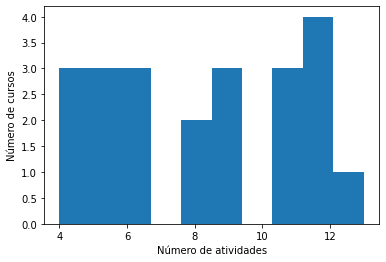

In [21]:
extra_counts = assessments.loc[assessments['assessment_type'] != 'Exam'].groupby(['code_module', 'code_presentation']).agg({'id_assessment':'count'})

plt.hist(extra_counts['id_assessment'])
plt.xlabel('Número de atividades')
plt.ylabel('Número de cursos')
plt.show()

In [22]:
extra_counts.id_assessment.describe()

count    22.000000
mean      8.272727
std       3.119552
min       4.000000
25%       5.250000
50%       8.500000
75%      11.000000
max      13.000000
Name: id_assessment, dtype: float64

Vemos que poucos cursos têm mais que 10 atividades extra, e em média cursos têm 8.27 atividades.

**Como é a distribuição dos pesos das atividades extras? E quando agrupamos por tipo?**

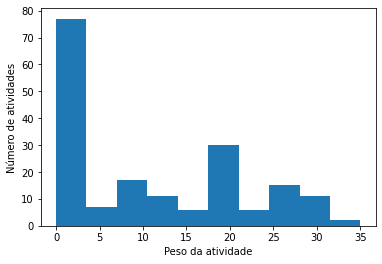

In [23]:
_ = assessments.loc[assessments['assessment_type'] != 'Exam']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.show()

Vemos que existe um grande número de atividades com peso 0, que correspondem às atividades do curso GGG, que dá peso 0 a tudo, menos à prova final. Além disso, temos um grande número de atividades com peso de 20% a 35%, e nenhuma atividade com peso entre 36% e 100%. O que indica que muitos cursos têm um grande número de atividades extras, concordando com o número médio de atividades que vimos anteriormente.

Agora, vou investigar a distribuição dos pesos quando agrupamos por tipo de atividade.

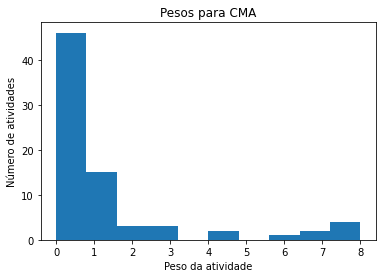

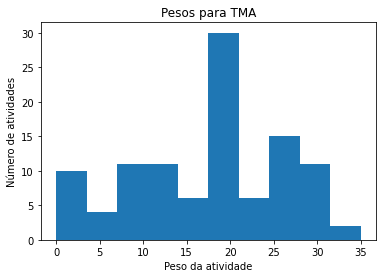

In [24]:
_ = assessments.loc[assessments['assessment_type'] != 'Exam'].loc[assessments['assessment_type'] == 'CMA']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.title('Pesos para CMA')
plt.show()
_ = assessments.loc[assessments['assessment_type'] != 'Exam'].loc[assessments['assessment_type'] == 'TMA']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.title('Pesos para TMA')
plt.show()

Vemos que atividades corrigidas por monitores (TMA) carregam mais peso. Assim, é possível interpretar CMAs como atividades menores, como trabalhos práticos, e TMAs como projetos de cursos, por exemplo.

**Como acontecem as atividades ao longo do curso?**

Veremos quais são as chances de existir uma atividade em cada um dos dias de um curso qualquer.

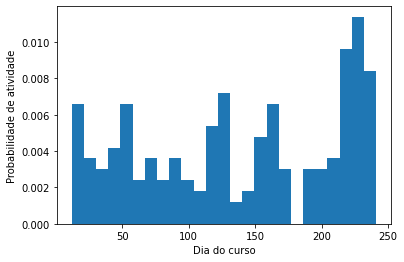

In [25]:
_ = assessments.dropna().loc[assessments['assessment_type'] != 'Exam']
plt.hist(_.date, bins = 25, density = True)
plt.ylabel('Probabilidade de atividade')
plt.xlabel('Dia do curso')
plt.show()

In [26]:
_.date.describe()

count    182.000000
mean     138.626374
std       74.633787
min       12.000000
25%       67.250000
50%      145.000000
75%      220.250000
max      241.000000
Name: date, dtype: float64

Vemos que existem picos ao longo do curso em que atividades são mais prováveis. Esses picos podem coincidir com o fim de módulos dentro de um curso, por exemplo. A atividade mais rápida dos cursos vence no dia 12, que pode corresponder a uma atividade de introdução ao conteúdo.

Além disso, chama a atenção um hiato por volta do dia 160~170 em que não existem atividades. Isso pode ser explicado como um período que os alunos têm para se preparar para as atividades finais do curso.

Esse gráfico poderia ser melhorado se normalizasse o dia de cada atividade usando a duração de cada oferta. Assim, deixaríamos de ter dias absolutos e passaríamos a ter porcentagem de conclusão de curso. Isso poderia inclusive mostrar características que independessem do mês de oferta.

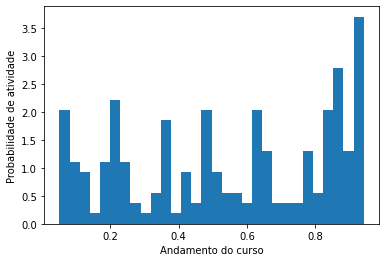

In [27]:
# Usei a função merge para realizar um join entre as duas tabelas.
# Mudei o índice das duas tabelas para as colunas que identificam unicamente cada entrada de curso
# Assim cada atividade ganha a informação da duração da oferta em que aconteceu
_ = assessments.set_index(['code_module','code_presentation']).merge(courses.set_index(['code_module','code_presentation']), left_index=True, right_index=True)
# Voltar com as colunas de índice para colunas normais
_ = _.reset_index()
# Filtrar linhas de provas finais
_ = _.loc[_['assessment_type'] != 'Exam']
# Criar a coluna de data relativa, que é a data em que uma atividade aconteceu, dividida pela duração do curso
_['relative_date'] = _['date']/_['module_presentation_length']

#Plotar o gráfico
plt.hist(_['relative_date'], bins = 30, density= True)
plt.ylabel('Probabilidade de atividade')
plt.xlabel('Andamento do curso')
plt.show()

Nessa nova versão, que leva em consideração o andamento relativo do curso, vemos que menos atividades vencem em 100% do curso, deixando essa data exclusivamente para provas. Além disso, vemos picos mais pronunciados.

### VLE

The csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded. The vle.csv file contains the following columns:

- **id_site:** an identification number of the material.
- **code_module:** an identification code for module.
- **code_presentation:** the identification code of presentation.
- **activity_type:** the role associated with the module material.
- **week_from:** the week from which the material is planned to be used.
- **week_to:** week until which the material is planned to be used.

#### Resumo

- ```id_site``` identifica um material
- ```activity_type``` categoriza o tipo de material
- ```week_from``` e ```week_to``` indicam quando o material é recomendado, quando é o caso


In [30]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN



#### Perguntas

- Um material pode estar associado a mais de um curso?
- Ofertas de um mesmo curso mudam os materiais oferecidos?
- Quais os tipos de material mais comuns?
- Quando materiais são mais recomendados?

Começo respondendo a primeira pergunta: **Um material pode estar associado a mais de um curso?**

In [32]:
vle.groupby(['id_site', 'code_module']).agg({'code_module':'count'}).code_module.value_counts()

1    6364
Name: code_module, dtype: int64

In [36]:
np.unique(vle.id_site.value_counts().values)

array([1])

Vemos que só existe o valor 1 na contagem de módulos distintos associados aos ids de materiais. Assim, um material é único. Consequentemente, a resposta para a pergunta 2: **Ofertas de um mesmo curso mudam os materiais oferecidos?** é não.

Porém pode ser o caso de um mesmo material ser referenciado por dois ou mais ids. Portanto, vou investigar se o mix de tipos de material permanece o mesmo.

In [63]:
# Criando um novo dataframe com o agrupamento de informações
# Agrupo por ofertas de módulos únicos e pelo tipo de material
# Assim, tenho a contagem de cada tipo de material fornecido em cada uma das ofertas
material_mix = vle.groupby([ 'code_module','code_presentation', 'activity_type']).agg({'activity_type': 'count'})

# Função para descobrir os módulos que possuem o mesmo mix de materiais
# Recebe um dataframe com o agrupamento de módulos e ofertas mostrando a contagem de cada tipo de material
# Retorna a lista com os módulos
def get_same_mixes(material_mix):

    # Lista para armazenar os módulos com o mesmo mix de materiais
    modules_same = []

    # Iterar sobre cada módulo no dataframe de entrada
    for module in np.unique(material_mix.index.get_level_values('code_module')):
        # Separa em um dataframe somente as entradas de um mesmo módulo
        module_mix = material_mix.loc[material_mix.index.get_level_values('code_module') == module]
        # Retira o código do módulo do indes desse novo dataframe
        module_mix = module_mix.droplevel('code_module')

        # Lista para armazenar as contagens de mix de materiais
        mix_values = []
        for presentation in np.unique(module_mix.index.get_level_values('code_presentation')):
            # Separa o dataframe contendo só o mix de materiais de uma oferta do módulo em questão
            presentation_mix = module_mix.loc[module_mix.index.get_level_values('code_presentation') == presentation]

            # Não consigo fazer hash com dicionários, então vou usar uma tupla com os valores de cada tipo
            # Posso ter colisão de hash se um curso resolver trocar todos os seus forums por pdfs
            # E ainda assim manter a ordenação alfabética dos tipos
            # Isso é pouco provável
            mix_dict = presentation_mix.to_dict()
            mix_values.append(tuple(mix_dict['activity_type'].values()))
        
        # Se o conjunto de valores do mix de materiais tiver tamanho 1, aquele módulo tem o mesmo mix.
        if len(set(mix_values)) == 1:
            modules_same.append(module)

    # Retorna a lista de módulos escolhido
    return modules_same

get_same_mixes(material_mix)
        

[]

Desenvolvi a função ```get_same_mixes``` partindo do princípio que, por mais que um id de material não se repita, um mesmo pdf, por exemplo, pode ter sido cadastrado com dois ids diferentes em ofertas distintas. Por isso, ao invés de analisar se um material se repete, vou analisar o mix de materiais, que é a quantidade de cada tipo de material que uma oferta disponibiliza. Se dois mixes forem identicos, então assumo que duas ofertas tiveram o mesmo conjunto de materiais.

Infelizmente, esse não foi o caso, pois a lista retornada está vazia. O que me leva à próxima pergunta:

** Quais os tipos de materiais mais comuns?**

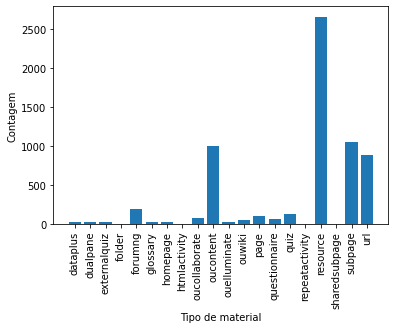

In [69]:
_ = vle.groupby('activity_type').agg({'activity_type': 'count'}).to_dict()
_ = _['activity_type']
types = _.keys()
counts = _.values()
plt.bar(types, counts)
plt.xticks(rotation=90)
plt.xlabel('Tipo de material')
plt.ylabel('Contagem')
plt.show()

Vemos que dois dos recursos mais utilizados parecem nomes genéricos: oucontent e resource. Interpreto oucontent como conteúdo externo e resource como arquivo anexado. Além desses dois, temos subpáginas como um dos itens mais referenciados, que acredito se tratarem de páginas para outros conteúdos dentro do mesmo curso, e URLs como links para sites externos.

**Quando materiais são mais recomendados?**

(array([127.,  92.,  68., 139.,  89.,  77., 163., 122.,  87., 157.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

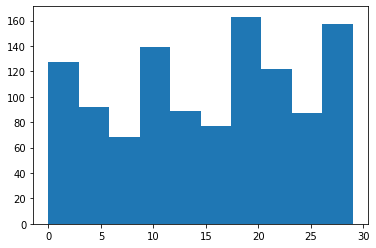

In [74]:
_ = vle.dropna()
plt.hist(_.week_from)

Essa medida de tempo é um pouco diferente da que estávamos lidando até então. Para chegar em dias contados, bastava multiplicar os dados de semana por 7. Entretanto, podemos ver os mesmos picos de atividades submetidas nas semanas em que materiais são recomendados.

## TODO

- O curso GGG só tem avaliação nas provas finais? Todas as outras atividades têm peso 0
- O curso CCC tem duas provas finais em cada uma das suas ofertas. Porém uma dessas provas parece estranha. Os alunos desse curso têm avaliações distintas para cada uma dessas provas? (Condição para 100% sim é que todos os alunos tenham registro de notas em cada uma das provas e pelo menos um aluno tenha avaliações distintas em cada uma delas. Fora isso, vou avaliar melhor os casos.)
- Existem provas finais sem data válida de aplicação. Na tabela de notas de alunos as datas são válidas?
- O fato do curso DDD ter pesos diferentes vai afetar o resultado?
- Preencher ```week_to``` e ```week_from``` inválidas com 0 e duração das ofertas.

Etapa 2: Defina qual pergunta você quer responder dentre as opções abaixo
Quais são os diferentes perfis de estudantes? Quais características definem esses grupos
Como predizer o desempenho dos estudantes nas avaliações finais?

Etapa 3: Crie o modelo e avalie sua qualidade e precisão

Etapa 4: Com base nas etapas anteriores, crie uma apresentação que responda às seguintes perguntas:

- Quais são as principais características da base de dados?
- Qual foi o problema de negócio escolhido?
- Qual foi o modelo utilizado e qual o motivo da escolha? Outros foram testados?
- Como você avalia os resultados obtidos?